In [ ]:
%matplotlib inline
import matplotlib.pylab as plt


# Comparing connectomes on different reference atlases

This examples shows how to turn a parcellation into connectome for
visualization. This requires choosing centers for each parcel
or network, via :func:`nilearn.plotting.find_parcellation_cut_coords` for
parcellation based on labels and
:func:`nilearn.plotting.find_probabilistic_atlas_cut_coords` for
parcellation based on probabilistic values.

In the intermediary steps, we make use of
:class:`nilearn.input_data.NiftiLabelsMasker` and
:class:`nilearn.input_data.NiftiMapsMasker` to extract time series from nifti
objects using different parcellation atlases.

The time series of all subjects of the brain development dataset are concatenated and
given directly to :class:`nilearn.connectome.ConnectivityMeasure` for
computing parcel-wise correlation matrices for each atlas across all subjects.

Mean correlation matrix is displayed on glass brain on extracted coordinates.

# author: Amadeus Kanaan


## Load atlases



In [ ]:
from nilearn import datasets

yeo = datasets.fetch_atlas_yeo_2011()
print('Yeo atlas nifti image (3D) with 17 parcels and liberal mask is located '
      'at: %s' % yeo['thick_17'])

Yeo atlas nifti image (3D) with 17 parcels and liberal mask is located at: /home/shuoz/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz


/home/shuoz/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Load functional data



In [ ]:
data = datasets.fetch_development_fmri(n_subjects=10)

print('Functional nifti images (4D, e.g., one subject) are located at : %r'
      % data['func'][0])
print('Counfound csv files (of same subject) are located at : %r'
      % data['confounds'][0])

Functional nifti images (4D, e.g., one subject) are located at : '/home/shuoz/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
Counfound csv files (of same subject) are located at : '/home/shuoz/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_desc-reducedConfounds_regressors.tsv'


## Extract coordinates on Yeo atlas - parcellations



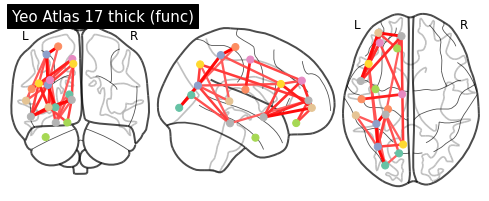

In [ ]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

# ConenctivityMeasure from Nilearn uses simple 'correlation' to compute
# connectivity matrices for all subjects in a list
connectome_measure = ConnectivityMeasure(kind='correlation')

# useful for plotting connectivity interactions on glass brain
from nilearn import plotting

# create masker to extract functional data within atlas parcels
masker = NiftiLabelsMasker(labels_img=yeo['thick_17'], standardize=True,
                           memory='nilearn_cache')

# extract time series from all subjects and concatenate them
time_series = []
for func, confounds in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func, confounds=confounds))

# calculate correlation matrices across subjects and display
correlation_matrices = connectome_measure.fit_transform(time_series)

# Mean correlation matrix across 10 subjects can be grabbed like this,
# using connectome measure object
mean_correlation_matrix = connectome_measure.mean_

# grab center coordinates for atlas labels
coordinates = plotting.find_parcellation_cut_coords(labels_img=yeo['thick_17'])

# plot connectome with 80% edge strength in the connectivity
plotting.plot_connectome(mean_correlation_matrix, coordinates,
                         edge_threshold="80%",
                         title='Yeo Atlas 17 thick (func)')

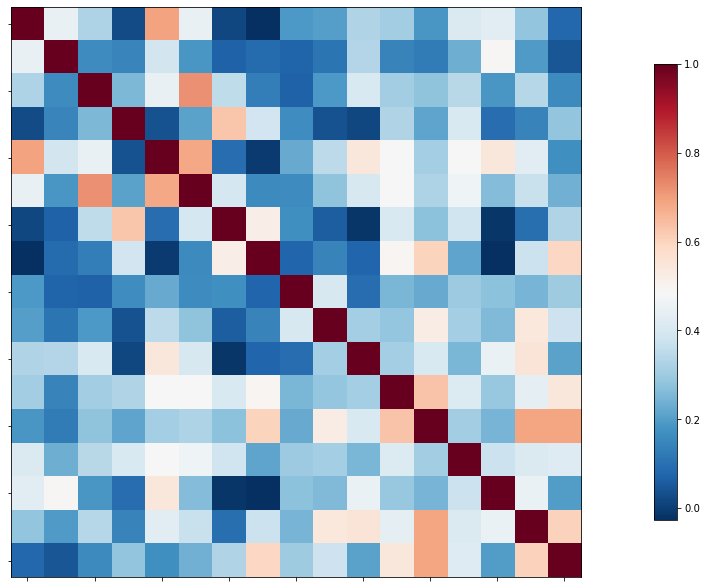

In [ ]:
plotting.plot_matrix(mean_correlation_matrix, figure=(10, 8))
#                      , labels=labels[1:], vmax=0.8, vmin=-0.8, reorder=True)

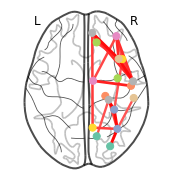

In [ ]:
# grab center coordinates for atlas labels
coordinates = plotting.find_parcellation_cut_coords(labels_img=yeo['thick_17'], label_hemisphere='right')

# plot connectome with 80% edge strength in the connectivity
plotting.plot_connectome(mean_correlation_matrix, coordinates,
                         edge_threshold="85%",
#                          title='Yeo Atlas 17 thick (func)'
                         display_mode = 'z'
                        )
plt.savefig('brain_network_R.svg', format='svg', bbox_inches='tight')

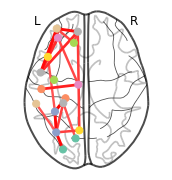

In [ ]:
coordinates = plotting.find_parcellation_cut_coords(labels_img=yeo['thick_17'], label_hemisphere='left')

# plot connectome with 80% edge strength in the connectivity
plotting.plot_connectome(mean_correlation_matrix, coordinates,
                         edge_threshold="85%",
                         display_mode = 'z'
#                          title='Yeo Atlas 17 thick (func)'
                        )
plt.savefig('brain_network_L.svg', format='svg', bbox_inches='tight')

In [ ]:
coordinates = plotting.find_probabilistic_atlas_cut_coords(maps_img=difumo.maps)

plotting.plot_connectome(mean_correlation_matrix, coordinates,
                         edge_threshold="85%",
                         display_mode = 'z'
#                          title='Yeo Atlas 17 thick (func)'
                        )

## Plot a directed connectome - asymmetric connectivity measure
In this section, we use the lag-1 correlation as the connectivity
measure, which leads to an asymmetric connectivity matrix.
The plot_connectome function accepts both symmetric and asymmetric
matrices, but plot the latter as a directed graph.



/home/shuoz/.local/lib/python3.8/site-packages/nilearn/plotting/displays.py:2204: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  warnings.warn(("'adjacency_matrix' is not symmetric. "


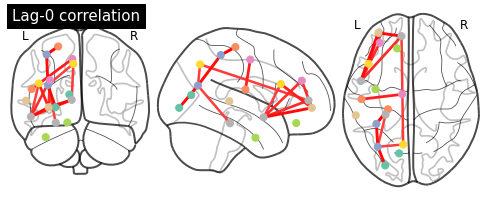

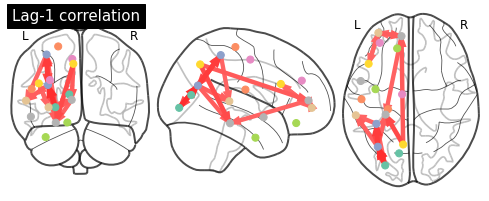

In [ ]:
import numpy as np

# Define a custom function to compute lag correlation on the time series
def lag_correlation(time_series, lag):
    n_subjects = len(time_series)
    n_samples, n_features = time_series[0].shape
    lag_cor = np.zeros((n_subjects, n_features, n_features))
    for subject, serie in enumerate(time_series):
        for i in range(n_features):
            for j in range(n_features):
                if lag == 0:
                    lag_cor[subject, i, j] = np.corrcoef(serie[:, i],
                                                         serie[:, j])[0, 1]
                else:
                    lag_cor[subject, i, j] = np.corrcoef(serie[lag:, i],
                                                         serie[:-lag, j])[0, 1]
    return np.mean(lag_cor, axis=0)

# Compute lag-0 and lag-1 correlations and plot associated connectomes
for lag in [0, 1]:
    lag_correlation_matrix = lag_correlation(time_series, lag)
    plotting.plot_connectome(lag_correlation_matrix, coordinates,
                             edge_threshold="90%",
                             title='Lag-{} correlation'.format(
                                 lag))

## Load probabilistic atlases - extracting coordinates on brain maps



In [ ]:
dim = 64
difumo = datasets.fetch_atlas_difumo(dimension=dim,
                                     resolution_mm=2)


Dataset created in C:\Users\sz144/nilearn_data\difumo_atlases



 ...done. (2 seconds, 0 min)
Extracting data from C:\Users\sz144/nilearn_data\difumo_atlases\76456e34a1d81298c1e6829633d44bb3\download..... done.
C:\Users\sz144\Anaconda3\lib\site-packages\numpy\lib\npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


 ...done. (2 seconds, 0 min)


## Iterate over fetched atlases to extract coordinates - probabilistic



C:\Users\sz144\AppData\Roaming\Python\Python38\site-packages\nilearn\_utils\cache_mixin.py:303: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "
C:\Users\sz144\AppData\Roaming\Python\Python38\site-packages\nilearn\input_data\nifti_maps_masker.py:297: UserWarning: Persisting input arguments took 5.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self._resampled_maps_img_ = self._cache(image.resample_img)(
C:\Users\sz144\AppData\Roaming\Python\Python38\site-packages\nilearn\input_data\nifti_maps_masker.py:339: UserWarning: Persisting input arguments took 0.51s to run.
If

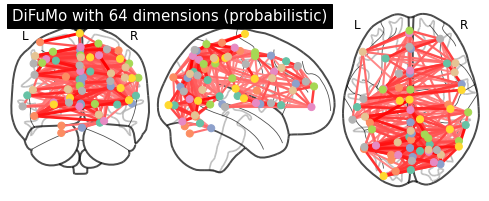

In [ ]:
from nilearn.input_data import NiftiMapsMasker

# create masker to extract functional data within atlas parcels
masker = NiftiMapsMasker(maps_img=difumo.maps, standardize=True,
                         memory='nilearn_cache')

# extract time series from all subjects and concatenate them
time_series = []
for func, confounds in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func, confounds=confounds))

# calculate correlation matrices across subjects and display
correlation_matrices = connectome_measure.fit_transform(time_series)

# Mean correlation matrix across 10 subjects can be grabbed like this,
# using connectome measure object
mean_correlation_matrix = connectome_measure.mean_

# grab center coordinates for probabilistic atlas
coordinates = plotting.find_probabilistic_atlas_cut_coords(maps_img=difumo.maps)

# plot connectome with 85% edge strength in the connectivity
plotting.plot_connectome(mean_correlation_matrix, coordinates,
                         edge_threshold="85%",
                         title='DiFuMo with {0} dimensions (probabilistic)'.format(dim))
plotting.show()